<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/Test_Again_Training_Exp02_to_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD
Test Again_training_Exp02 to MNIST dataset<br>
* test
    * save epoch per latent vector
    * plot epoch per 2-dim vector

* Try Again, Fin...Fin...Fin...!!
* back to Original Kingma's VAE to Malimg
    * optimizer learning rate: 1e-3
    * optimizer params: sum to mean
* Add 
    * plot train, test loss
        * save it every Epochs
    * plot latent vector per 10 Epoch
        * save it every 10 Epoch
    * save model's state dict per 10 Epoch
    * save latent vector per 10 Epoch

* ✅ Check Point
    * Just try it again...!
    * 
    * 
    
## Reference
* Reference repository: https://github.com/pytorch/examples/tree/master/vae

* Reference for Visualization: https://github.com/tayden/VAE-Latent-Space-Explorer/blob/master/scripts/VAE.ipynb


In [1]:
! nvidia-smi

Fri Jul  3 03:25:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
# drive mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
%cd drive/My\ Drive/InfoSec_Summer_part2
! pwd

/content/drive/My Drive/InfoSec_Summer_part2
/content/drive/My Drive/InfoSec_Summer_part2


## 01. Import Library

In [6]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
import seaborn as sns

# save single numpy array
# https://numpy.org/doc/stable/reference/generated/numpy.save.html#numpy.save
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 02. Data Preprocessing
* Load dataset
* preprocess it
    * transforms
    * make custom dataset
    * train_test split: <code>torch.utils.data.random_split</code>
    * train_test_loader

### Work Flow
* transforms module 사용해서 image data compose 하기
    * size 조정, normalize, tensor 변환
* ImageFolder를 이용해 dataload
* dataset split: train dataset, test dataset
* DataLoader로 batch단위 dataset 불러오기

In [7]:
# Tutorial of VAE
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=16, shuffle=True)

# for visualizing extract 1000 samples from test dataset
test_loader_1000 = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=1000, shuffle=True)

## 03. Define VAE Class
* Initialize
    * (224, 224) input 이미지를 통해 1차원 100개의 latent vector를 생성하는 Encoder네트워크 정의
    * 100개의 latent vector로부터 X_hat을 복원하는 Decoder Network 정의
* encode
* reparameterize
* decode
* forward

In [8]:
device = torch.device("cuda")  # device = torch.device("cuda")

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(28*28, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1000)
        self.fc4 = nn.Linear(1000, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)  # z's shape => (batch_size, 100)
        return self.decode(z), mu, logvar, z

In [9]:
model = VAE().to(device)
print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc21): Linear(in_features=1000, out_features=100, bias=True)
  (fc22): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=784, bias=True)
)


In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
# track and save train, test loss through Dictionary
# 
Epoch_Loss = {'train_epoch':[],
              'train_loss':[],
              'test_epoch':[],
              'test_loss':[]}

# Save & Loading Model for Inference
# Reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html

# PATH = '/Again_original_Exp01_200-Epoch.pth'

PATH = 'Epochs.pth'
latent_vector = np.zeros((16, 100))


In [14]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')  # (input, target, ... reduction)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    # latent_vector = np.zeros(())
    # latent_label = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, z= model(data)
    
       
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    Epoch_Loss['train_epoch'].append(epoch)
    Epoch_Loss['train_loss'].append(train_loss / len(train_loader.dataset))
   
    '''
    # Epoch 단위 t-SNE plot 저장
    Z_embedded = TSNE(n_components=2).fit_transform(latent_vector.detach().cpu().clone().numpy())
    print(Z_embedded.shape)  # expect (16, 2)
    # https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
    plt.figure(figsize=(16,10))
    plt.xlim(Z_embedded[:, 0].min(), Z_embedded[:,0].max() + 1)
    plt.ylim(Z_embedded[:, 1].min(), Z_embedded[:,1].max() + 1)
    
    for i in range(len(Z_embedded[0])):
        plt.text(Z_embedded[i, 0], Z_embedded[i, 1], str(batch_idx),
                # color = colors[label[i]],
                fontdict={'weight':'bold', 'size':9})
    plt.xlabel("t-SNE feature 0")
    plt.ylabel("t-SNE feature 1")
    plt.savefig('./' + str(epoch) + '_t_SNE.png', dpi=300)
    '''
def test(epoch):
    if epoch % 10 !=0:
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(test_loader):
                data = data.to(device)
                recon_batch, mu, logvar, z = model(data)
                # z vector는 torch type
                # latent_vector = z.detach().cpu().clone().numpy()
                test_loss += loss_function(recon_batch, data, mu, logvar).item()
                if i == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([data[:n],
                                        recon_batch.view(16, 1, 28, 28)[:n]])
                    save_image(comparison.cpu(),
                            './test_result_MNIST/reconstruction_' + str(epoch) + '.png', nrow=n)
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))

    # 10 Epoch 단위로 작업
    # model.state_dict() 저장 및 latent_vector 저장
    # plot latent vector
    elif epoch % 10 == 0:  # Epoch이 10의 배수일때
        latent_vector = np.zeros((1000, 100))
        # save model.state_dict() per 10 Epochs
        torch.save(model.state_dict(), ('/test_MNIST' + str(epoch) + PATH))  # Epoch 단위 parameter 저장

        # load_whole test_data 
        for i, (data, _) in enumerate(test_loader_1000):  # load_whole test_data
            data = data.to(device)
            recon_batch, mu, logvar, z = model(data)
        # save latent_vector per 10 Epochs
            latent_vector = z.detach().cpu().clone().numpy()  # change tensor type data to cpu().numpy()
                                                              # latent_vector_size: (num_of_data, 100)
            with open(('Test'+str(epoch)+'Epoch_z_vector.npy'), 'wb') as f:
                np.save(f, latent_vector)  # but latent vector size is (16, 100).... just 16...
                                        # 10 Epoch 단위로 latent vector를 저장한다
                                        # 이 떄, latent vector의 size는 test_dataset의 크기가 되어야 한다

        # plot latent vector Every 10 Epochs
        # t-SNE for Dimensionality reduction
        Z_embedded = TSNE(n_components=2).fit_transform(latent_vector.detach().cpu().clone().numpy())
        print(Z_embedded.shape)  # expect (16, 2) 
                                    # https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

        # display a 2D plot of the digit classes in the latent space
        x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
        plt.figure(figsize=(6, 6))
        plt.scatter(Z_embedded[:, 0], Z_embedded[:, 1], c=y_test)
        plt.colorbar()
        plt.savefig('./Test_' + str(epoch) + '_t_SNE.png', dpi=300)
        plt.show()

1
Train Epoch: 1 [0/60000 (0%)]	Loss: 101.613144
Train Epoch: 1 [160/60000 (0%)]	Loss: 111.040047
Train Epoch: 1 [320/60000 (1%)]	Loss: 98.326637
Train Epoch: 1 [480/60000 (1%)]	Loss: 115.376694
Train Epoch: 1 [640/60000 (1%)]	Loss: 99.117569
Train Epoch: 1 [800/60000 (1%)]	Loss: 98.155563
Train Epoch: 1 [960/60000 (2%)]	Loss: 103.899071
Train Epoch: 1 [1120/60000 (2%)]	Loss: 98.157318
Train Epoch: 1 [1280/60000 (2%)]	Loss: 114.097618
Train Epoch: 1 [1440/60000 (2%)]	Loss: 110.365067
Train Epoch: 1 [1600/60000 (3%)]	Loss: 99.658051
Train Epoch: 1 [1760/60000 (3%)]	Loss: 115.094261
Train Epoch: 1 [1920/60000 (3%)]	Loss: 101.074028
Train Epoch: 1 [2080/60000 (3%)]	Loss: 102.244400
Train Epoch: 1 [2240/60000 (4%)]	Loss: 107.337189
Train Epoch: 1 [2400/60000 (4%)]	Loss: 102.436874
Train Epoch: 1 [2560/60000 (4%)]	Loss: 113.526138
Train Epoch: 1 [2720/60000 (5%)]	Loss: 98.783798
Train Epoch: 1 [2880/60000 (5%)]	Loss: 88.970139
Train Epoch: 1 [3040/60000 (5%)]	Loss: 105.561432
Train Epoch: 1

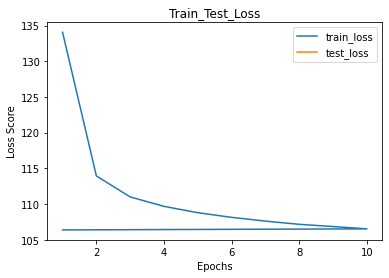

2
Train Epoch: 2 [0/60000 (0%)]	Loss: 98.673103
Train Epoch: 2 [160/60000 (0%)]	Loss: 102.572388
Train Epoch: 2 [320/60000 (1%)]	Loss: 118.500992
Train Epoch: 2 [480/60000 (1%)]	Loss: 102.321716
Train Epoch: 2 [640/60000 (1%)]	Loss: 111.034470
Train Epoch: 2 [800/60000 (1%)]	Loss: 102.836243
Train Epoch: 2 [960/60000 (2%)]	Loss: 98.736633
Train Epoch: 2 [1120/60000 (2%)]	Loss: 90.932693
Train Epoch: 2 [1280/60000 (2%)]	Loss: 99.048958
Train Epoch: 2 [1440/60000 (2%)]	Loss: 96.316483
Train Epoch: 2 [1600/60000 (3%)]	Loss: 96.593536
Train Epoch: 2 [1760/60000 (3%)]	Loss: 113.321671
Train Epoch: 2 [1920/60000 (3%)]	Loss: 112.490616
Train Epoch: 2 [2080/60000 (3%)]	Loss: 108.442123
Train Epoch: 2 [2240/60000 (4%)]	Loss: 102.411034
Train Epoch: 2 [2400/60000 (4%)]	Loss: 108.922226
Train Epoch: 2 [2560/60000 (4%)]	Loss: 99.712730
Train Epoch: 2 [2720/60000 (5%)]	Loss: 111.815399
Train Epoch: 2 [2880/60000 (5%)]	Loss: 107.324432
Train Epoch: 2 [3040/60000 (5%)]	Loss: 111.842545
Train Epoch: 2

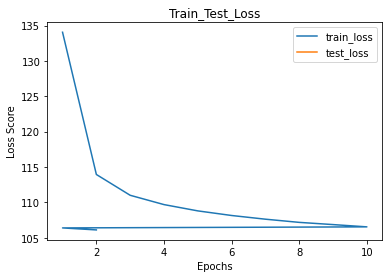

3
Train Epoch: 3 [0/60000 (0%)]	Loss: 104.466858
Train Epoch: 3 [160/60000 (0%)]	Loss: 104.986649
Train Epoch: 3 [320/60000 (1%)]	Loss: 107.669060
Train Epoch: 3 [480/60000 (1%)]	Loss: 103.229301
Train Epoch: 3 [640/60000 (1%)]	Loss: 96.050476
Train Epoch: 3 [800/60000 (1%)]	Loss: 99.608109
Train Epoch: 3 [960/60000 (2%)]	Loss: 110.131836
Train Epoch: 3 [1120/60000 (2%)]	Loss: 97.670090
Train Epoch: 3 [1280/60000 (2%)]	Loss: 112.015091
Train Epoch: 3 [1440/60000 (2%)]	Loss: 103.222267
Train Epoch: 3 [1600/60000 (3%)]	Loss: 108.689774
Train Epoch: 3 [1760/60000 (3%)]	Loss: 105.373001
Train Epoch: 3 [1920/60000 (3%)]	Loss: 112.252525
Train Epoch: 3 [2080/60000 (3%)]	Loss: 101.686729
Train Epoch: 3 [2240/60000 (4%)]	Loss: 100.483894
Train Epoch: 3 [2400/60000 (4%)]	Loss: 112.910309
Train Epoch: 3 [2560/60000 (4%)]	Loss: 98.107147
Train Epoch: 3 [2720/60000 (5%)]	Loss: 110.489204
Train Epoch: 3 [2880/60000 (5%)]	Loss: 102.431908
Train Epoch: 3 [3040/60000 (5%)]	Loss: 104.800911
Train Epoch

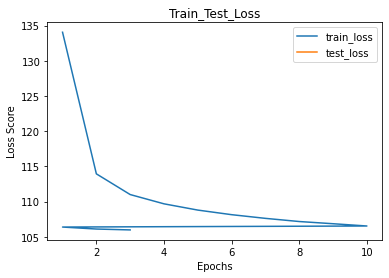

4
Train Epoch: 4 [0/60000 (0%)]	Loss: 108.454910
Train Epoch: 4 [160/60000 (0%)]	Loss: 109.726822
Train Epoch: 4 [320/60000 (1%)]	Loss: 102.788788
Train Epoch: 4 [480/60000 (1%)]	Loss: 102.814697
Train Epoch: 4 [640/60000 (1%)]	Loss: 113.541801
Train Epoch: 4 [800/60000 (1%)]	Loss: 101.741196
Train Epoch: 4 [960/60000 (2%)]	Loss: 104.924049
Train Epoch: 4 [1120/60000 (2%)]	Loss: 96.969765
Train Epoch: 4 [1280/60000 (2%)]	Loss: 91.456802
Train Epoch: 4 [1440/60000 (2%)]	Loss: 109.223511
Train Epoch: 4 [1600/60000 (3%)]	Loss: 99.312775
Train Epoch: 4 [1760/60000 (3%)]	Loss: 107.788284
Train Epoch: 4 [1920/60000 (3%)]	Loss: 102.929581
Train Epoch: 4 [2080/60000 (3%)]	Loss: 111.726273
Train Epoch: 4 [2240/60000 (4%)]	Loss: 103.860565
Train Epoch: 4 [2400/60000 (4%)]	Loss: 96.376083
Train Epoch: 4 [2560/60000 (4%)]	Loss: 108.172867
Train Epoch: 4 [2720/60000 (5%)]	Loss: 104.333199
Train Epoch: 4 [2880/60000 (5%)]	Loss: 109.720337
Train Epoch: 4 [3040/60000 (5%)]	Loss: 104.082504
Train Epoch

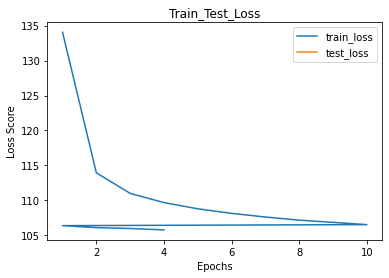

5
Train Epoch: 5 [0/60000 (0%)]	Loss: 101.423172
Train Epoch: 5 [160/60000 (0%)]	Loss: 111.677353
Train Epoch: 5 [320/60000 (1%)]	Loss: 108.645081
Train Epoch: 5 [480/60000 (1%)]	Loss: 110.839798
Train Epoch: 5 [640/60000 (1%)]	Loss: 112.109421
Train Epoch: 5 [800/60000 (1%)]	Loss: 98.996651
Train Epoch: 5 [960/60000 (2%)]	Loss: 93.828606
Train Epoch: 5 [1120/60000 (2%)]	Loss: 109.236244
Train Epoch: 5 [1280/60000 (2%)]	Loss: 99.217010
Train Epoch: 5 [1440/60000 (2%)]	Loss: 105.511017
Train Epoch: 5 [1600/60000 (3%)]	Loss: 107.879608
Train Epoch: 5 [1760/60000 (3%)]	Loss: 96.542114
Train Epoch: 5 [1920/60000 (3%)]	Loss: 107.724052
Train Epoch: 5 [2080/60000 (3%)]	Loss: 103.458755
Train Epoch: 5 [2240/60000 (4%)]	Loss: 102.348534
Train Epoch: 5 [2400/60000 (4%)]	Loss: 107.024567
Train Epoch: 5 [2560/60000 (4%)]	Loss: 102.568108
Train Epoch: 5 [2720/60000 (5%)]	Loss: 103.016403
Train Epoch: 5 [2880/60000 (5%)]	Loss: 113.840256
Train Epoch: 5 [3040/60000 (5%)]	Loss: 104.140533
Train Epoch

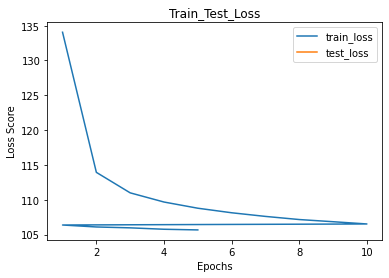

6
Train Epoch: 6 [0/60000 (0%)]	Loss: 108.502563
Train Epoch: 6 [160/60000 (0%)]	Loss: 94.697601
Train Epoch: 6 [320/60000 (1%)]	Loss: 105.913528
Train Epoch: 6 [480/60000 (1%)]	Loss: 110.235107
Train Epoch: 6 [640/60000 (1%)]	Loss: 99.345779
Train Epoch: 6 [800/60000 (1%)]	Loss: 98.609123
Train Epoch: 6 [960/60000 (2%)]	Loss: 105.817993
Train Epoch: 6 [1120/60000 (2%)]	Loss: 110.690010
Train Epoch: 6 [1280/60000 (2%)]	Loss: 100.087517
Train Epoch: 6 [1440/60000 (2%)]	Loss: 104.609856
Train Epoch: 6 [1600/60000 (3%)]	Loss: 105.379181
Train Epoch: 6 [1760/60000 (3%)]	Loss: 109.985161
Train Epoch: 6 [1920/60000 (3%)]	Loss: 99.745628
Train Epoch: 6 [2080/60000 (3%)]	Loss: 97.939804
Train Epoch: 6 [2240/60000 (4%)]	Loss: 108.325104
Train Epoch: 6 [2400/60000 (4%)]	Loss: 110.531830
Train Epoch: 6 [2560/60000 (4%)]	Loss: 106.796982
Train Epoch: 6 [2720/60000 (5%)]	Loss: 106.917511
Train Epoch: 6 [2880/60000 (5%)]	Loss: 109.424278
Train Epoch: 6 [3040/60000 (5%)]	Loss: 107.471436
Train Epoch:

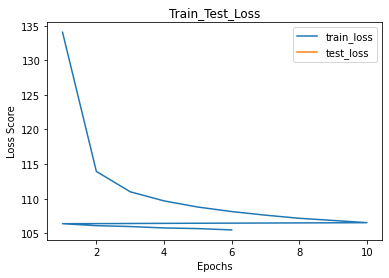

7
Train Epoch: 7 [0/60000 (0%)]	Loss: 113.283340
Train Epoch: 7 [160/60000 (0%)]	Loss: 100.416466
Train Epoch: 7 [320/60000 (1%)]	Loss: 109.620537
Train Epoch: 7 [480/60000 (1%)]	Loss: 106.963699
Train Epoch: 7 [640/60000 (1%)]	Loss: 88.026924
Train Epoch: 7 [800/60000 (1%)]	Loss: 105.651611
Train Epoch: 7 [960/60000 (2%)]	Loss: 99.421883
Train Epoch: 7 [1120/60000 (2%)]	Loss: 105.912109
Train Epoch: 7 [1280/60000 (2%)]	Loss: 111.385574
Train Epoch: 7 [1440/60000 (2%)]	Loss: 95.085968
Train Epoch: 7 [1600/60000 (3%)]	Loss: 105.856049
Train Epoch: 7 [1760/60000 (3%)]	Loss: 101.723541
Train Epoch: 7 [1920/60000 (3%)]	Loss: 100.195747
Train Epoch: 7 [2080/60000 (3%)]	Loss: 115.740219
Train Epoch: 7 [2240/60000 (4%)]	Loss: 112.882042
Train Epoch: 7 [2400/60000 (4%)]	Loss: 104.748222
Train Epoch: 7 [2560/60000 (4%)]	Loss: 101.341492
Train Epoch: 7 [2720/60000 (5%)]	Loss: 105.549004
Train Epoch: 7 [2880/60000 (5%)]	Loss: 102.211502
Train Epoch: 7 [3040/60000 (5%)]	Loss: 107.773003
Train Epoc

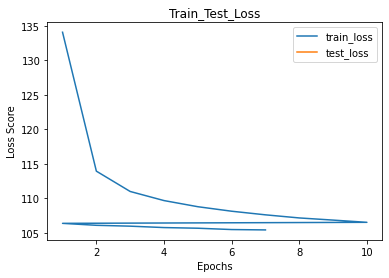

8
Train Epoch: 8 [0/60000 (0%)]	Loss: 109.427399
Train Epoch: 8 [160/60000 (0%)]	Loss: 98.712280
Train Epoch: 8 [320/60000 (1%)]	Loss: 101.789734
Train Epoch: 8 [480/60000 (1%)]	Loss: 111.790588
Train Epoch: 8 [640/60000 (1%)]	Loss: 105.294510
Train Epoch: 8 [800/60000 (1%)]	Loss: 103.996948
Train Epoch: 8 [960/60000 (2%)]	Loss: 102.602287
Train Epoch: 8 [1120/60000 (2%)]	Loss: 96.352142
Train Epoch: 8 [1280/60000 (2%)]	Loss: 104.572304
Train Epoch: 8 [1440/60000 (2%)]	Loss: 103.373802
Train Epoch: 8 [1600/60000 (3%)]	Loss: 108.853287
Train Epoch: 8 [1760/60000 (3%)]	Loss: 115.951569
Train Epoch: 8 [1920/60000 (3%)]	Loss: 111.591614
Train Epoch: 8 [2080/60000 (3%)]	Loss: 96.705734
Train Epoch: 8 [2240/60000 (4%)]	Loss: 108.519699
Train Epoch: 8 [2400/60000 (4%)]	Loss: 103.158630
Train Epoch: 8 [2560/60000 (4%)]	Loss: 101.207428
Train Epoch: 8 [2720/60000 (5%)]	Loss: 94.698570
Train Epoch: 8 [2880/60000 (5%)]	Loss: 100.400894
Train Epoch: 8 [3040/60000 (5%)]	Loss: 105.529991
Train Epoch

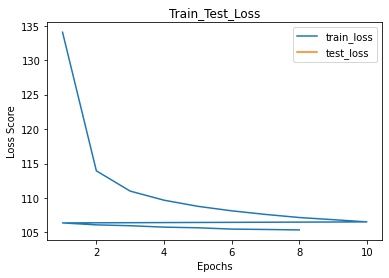

9
Train Epoch: 9 [0/60000 (0%)]	Loss: 104.568558
Train Epoch: 9 [160/60000 (0%)]	Loss: 107.325935
Train Epoch: 9 [320/60000 (1%)]	Loss: 98.939819
Train Epoch: 9 [480/60000 (1%)]	Loss: 94.122475
Train Epoch: 9 [640/60000 (1%)]	Loss: 104.301331
Train Epoch: 9 [800/60000 (1%)]	Loss: 111.420120
Train Epoch: 9 [960/60000 (2%)]	Loss: 105.528084
Train Epoch: 9 [1120/60000 (2%)]	Loss: 109.610168
Train Epoch: 9 [1280/60000 (2%)]	Loss: 96.841705
Train Epoch: 9 [1440/60000 (2%)]	Loss: 103.203819
Train Epoch: 9 [1600/60000 (3%)]	Loss: 102.878029
Train Epoch: 9 [1760/60000 (3%)]	Loss: 101.712639
Train Epoch: 9 [1920/60000 (3%)]	Loss: 107.706398
Train Epoch: 9 [2080/60000 (3%)]	Loss: 110.482826
Train Epoch: 9 [2240/60000 (4%)]	Loss: 106.112915
Train Epoch: 9 [2400/60000 (4%)]	Loss: 95.190247
Train Epoch: 9 [2560/60000 (4%)]	Loss: 96.898682
Train Epoch: 9 [2720/60000 (5%)]	Loss: 99.713371
Train Epoch: 9 [2880/60000 (5%)]	Loss: 105.759804
Train Epoch: 9 [3040/60000 (5%)]	Loss: 102.294441
Train Epoch: 

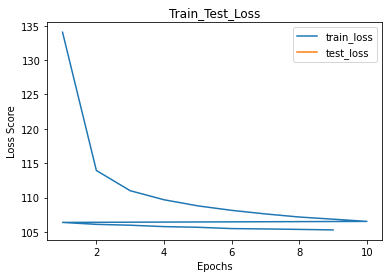

10
Train Epoch: 10 [0/60000 (0%)]	Loss: 110.788475
Train Epoch: 10 [160/60000 (0%)]	Loss: 106.826782
Train Epoch: 10 [320/60000 (1%)]	Loss: 102.815590
Train Epoch: 10 [480/60000 (1%)]	Loss: 101.312683
Train Epoch: 10 [640/60000 (1%)]	Loss: 102.884232
Train Epoch: 10 [800/60000 (1%)]	Loss: 100.155777
Train Epoch: 10 [960/60000 (2%)]	Loss: 108.577805
Train Epoch: 10 [1120/60000 (2%)]	Loss: 98.862419
Train Epoch: 10 [1280/60000 (2%)]	Loss: 107.079834
Train Epoch: 10 [1440/60000 (2%)]	Loss: 109.409561
Train Epoch: 10 [1600/60000 (3%)]	Loss: 105.043396
Train Epoch: 10 [1760/60000 (3%)]	Loss: 109.201653
Train Epoch: 10 [1920/60000 (3%)]	Loss: 102.832062
Train Epoch: 10 [2080/60000 (3%)]	Loss: 106.786560
Train Epoch: 10 [2240/60000 (4%)]	Loss: 112.382553
Train Epoch: 10 [2400/60000 (4%)]	Loss: 97.530724
Train Epoch: 10 [2560/60000 (4%)]	Loss: 94.933456
Train Epoch: 10 [2720/60000 (5%)]	Loss: 108.668121
Train Epoch: 10 [2880/60000 (5%)]	Loss: 96.684387
Train Epoch: 10 [3040/60000 (5%)]	Loss: 1

NameError: ignored

In [15]:
epochs = 20

for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)

        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss")
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./test_plot_MNIST/'+str(epoch)+'_epoch.png', dpi=300)
        plt.show()

        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       './test_result_MNIST/sample_' + str(epoch) + '.png')

In [ ]:
# Reference: https://github.com/tayden/VAE-Latent-Space-Explorer/blob/master/scripts/VAE.ipynb

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

encoder.save('encoder.h5')

NameError: ignored